In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

#setup y
y_cols = ['Ever Enrolled Count','DP03_0095E'] #just predict mkt share
    
x_cols = []
for col in df1.columns:
    if col not in y_cols and col not in keys: 
        x_cols.append(col)  

In [4]:
X_train = df1[x_cols]
X_train = X_train/X_train.std()

X_test = df2[x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

share_train = df1[y_cols]
share_test = df2[y_cols]
share_test = share_test.fillna(0) #TODO: Why are there 0s???

y_train = (share_train['Ever Enrolled Count']/share_train['DP03_0095E']).to_frame()

In [5]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,share_test):
    #setup the data
    share_test = np.array(share_test)
    y_pred = y_pred.flatten()*share_test[:,1]
    y_test = share_test[:,0]
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

def get_mse(y_pred,share_test):
    share_test = np.array(share_test)
    #ever enrolled count is column 0... want to weight mse by mkt size
    return (np.array(y_pred).flatten()*share_test[:,1] - share_test[:,0])**2


def plot_importance(X_test,model,v=False):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()
    if v:
        print(importance['features'].head(20))

mse 47332396.84113568


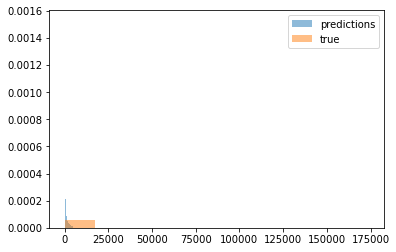

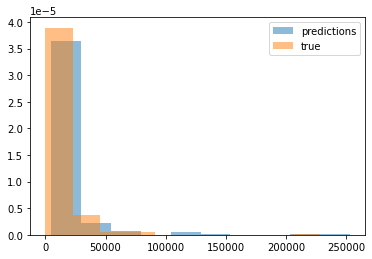

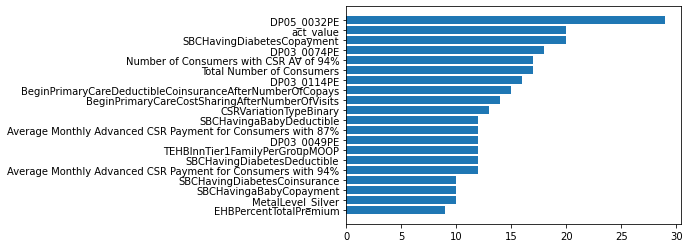

164                                          DP05_0032PE
44                                             act_value
35                            SBCHavingDiabetesCopayment
100                                          DP03_0074PE
197               Number of Consumers with CSR AV of 94%
194                            Total Number of Consumers
126                                          DP03_0114PE
2      BeginPrimaryCareDeductibleCoinsuranceAfterNumb...
1         BeginPrimaryCareCostSharingAfterNumberOfVisits
3                                 CSRVariationTypeBinary
32                              SBCHavingaBabyDeductible
199    Average Monthly Advanced CSR Payment for Consu...
84                                           DP03_0049PE
38                        TEHBInnTier1FamilyPerGroupMOOP
34                           SBCHavingDiabetesDeductible
200    Average Monthly Advanced CSR Payment for Consu...
40                          SBCHavingDiabetesCoinsurance
41                             

In [6]:
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)

mse = get_mse(y_pred,share_test)
print( 'mse', mse.mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,share_test)
plot_importance(X_test,model,v=True)

In [7]:
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(20)

    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse 40245495.365174465


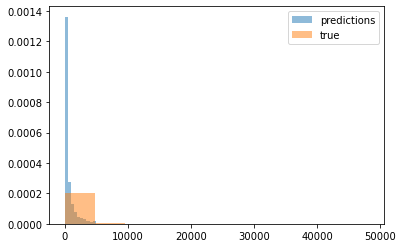

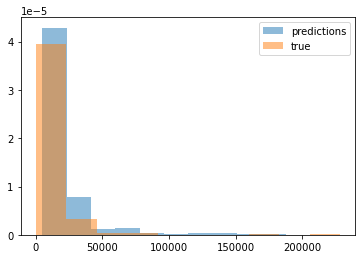

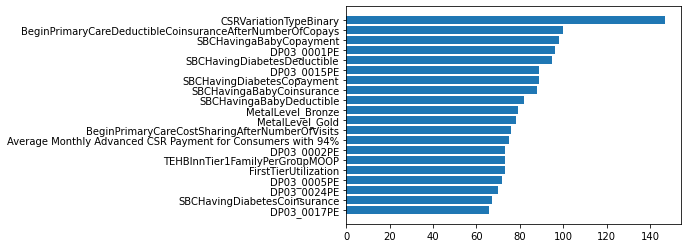

In [8]:
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)

mse = get_mse(y_pred,share_test)
print( 'mse', mse.mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,share_test)
plot_importance(X_test,model)

alpha_value: 100 mse 32903995.444279697


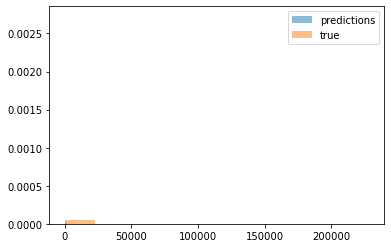

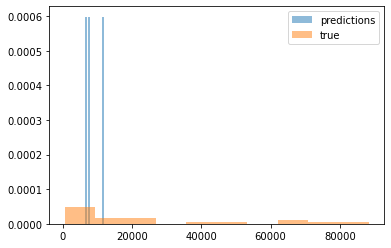

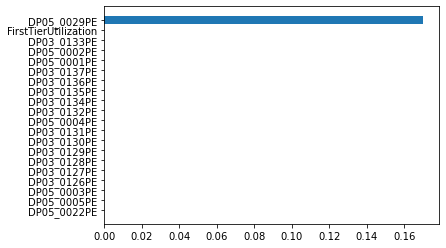

DP05_0022PE             0.000000
DP05_0005PE             0.000000
DP05_0003PE             0.000000
DP03_0126PE             0.000000
DP03_0127PE             0.000000
DP03_0128PE             0.000000
DP03_0129PE             0.000000
DP03_0130PE             0.000000
DP03_0131PE             0.000000
DP05_0004PE             0.000000
DP03_0132PE             0.000000
DP03_0134PE             0.000000
DP03_0135PE             0.000000
DP03_0136PE             0.000000
DP03_0137PE             0.000000
DP05_0001PE             0.000000
DP05_0002PE             0.000000
DP03_0133PE             0.000000
FirstTierUtilization    0.000000
DP05_0029PE             0.170203
Name: score, dtype: float64
alpha_value: 250 mse 33292653.253658887


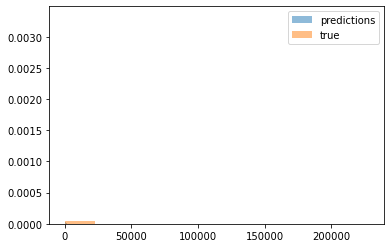

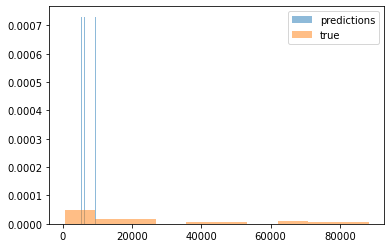

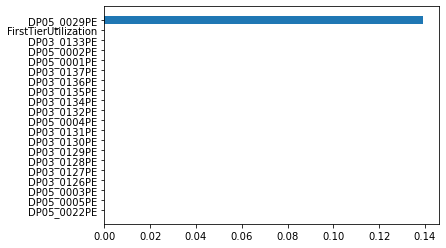

DP05_0022PE             0.000000
DP05_0005PE             0.000000
DP05_0003PE             0.000000
DP03_0126PE             0.000000
DP03_0127PE             0.000000
DP03_0128PE             0.000000
DP03_0129PE             0.000000
DP03_0130PE             0.000000
DP03_0131PE             0.000000
DP05_0004PE             0.000000
DP03_0132PE             0.000000
DP03_0134PE             0.000000
DP03_0135PE             0.000000
DP03_0136PE             0.000000
DP03_0137PE             0.000000
DP05_0001PE             0.000000
DP05_0002PE             0.000000
DP03_0133PE             0.000000
FirstTierUtilization    0.000000
DP05_0029PE             0.139328
Name: score, dtype: float64


In [9]:


# Vary alpha values
a = [100,250]
for i in a: 
    lasso = sm.OLS(1000*y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,X_test/1000)
    mse = get_mse(y_pred,share_test)
    print('alpha_value:', i, 'mse', mse.mean()) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,share_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),
                            columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(param_df['score'].iloc[::-1])